In [296]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
import os
import itertools
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.random import sample_without_replacement

pd.options.display.float_format = '{:.2f}'.format


In [297]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import top_k_accuracy_score, accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
import gensim
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [298]:
import pickle # for loading (and saving) the previously web scraped data

import matplotlib.pyplot as plt # for plotting

import re # for cleaning textual data (uses regular expressions ouch!)
from collections import Counter # for counting tokens occurences
import math # for calculations

import nltk
from nltk.tokenize import word_tokenize # for tokenization
from nltk.stem import PorterStemmer # for stemming
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# import stop_words # source: https://pypi.org/project/stop-words/#installation
# from stop_words import get_stop_words # alternative stopwords list

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

import statistics # for: quantiles()

import numpy as np # for some maths

import time # for measuring time of computation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [299]:

fulldata = pd.read_csv('fulldata-updated.csv')
fulldata = fulldata.drop_duplicates(subset= ['title'], ignore_index= True).reset_index(drop=True).convert_dtypes()
fulldata

,Unnamed: 0,title,link,label,date,article
0,0,Pope Benedict was first pontiff to resign in 6...,https://www.reuters.com/world/obituary-former-...,World,2022-12-31T12:03:04Z,"VATICAN CITY, Dec 31 - Former Pope Benedict, ..."
1,4,Norrie stuns Nadal as Britain lead Spain 2-0 i...,https://www.reuters.com/lifestyle/sports/norri...,Lifestyle,2022-12-31T11:35:20Z,"SYDNEY, Dec 31 (Reuters) - Rafa Nadal's prepa..."
2,8,Russia's Putin clears foreign currency settlem...,https://www.reuters.com/business/energy/russia...,Business,2022-12-30T21:13:24Z,"MOSCOW, Dec 30 (Reuters) - Russia will allow ..."
3,12,Barcelona were prepared to face Espanyol witho...,https://www.reuters.com/lifestyle/sports/barce...,Lifestyle,2022-12-30T14:32:05Z,Dec 30 (Reuters) - Barcelona manager Xavi Her...
4,16,Belarus official: 'Unlikely' downed Ukrainian ...,https://www.reuters.com/world/europe/belarus-o...,World,2022-12-30T13:33:43Z,Dec 30 (Reuters) - The secretary of Belarus' ...
...,...,...,...,...,...,...
553,856,"EU set to train 15,000 Ukrainian troops, provi...",https://www.reuters.com/world/europe/eu-set-tr...,World,2022-10-17T05:04:32Z,"BRUSSELS, Oct 17 (Reuters) - European Union f..."
554,857,EU leaders set to explore gas price cap option...,https://www.reuters.com/business/energy/eu-lea...,Business,2022-10-16T19:09:28Z,"BRUSSELS, Oct 16 (Reuters) - European Union l..."
555,858,Poland must fight for second spot in World Cup...,https://www.reuters.com/lifestyle/sports/polan...,Lifestyle,2022-10-15T03:06:44Z,"MEXICO CITY, Oct 14 (Reuters) - Poland must f..."
556,859,Messi worried by Dybala and Di Maria injuries ...,https://www.reuters.com/lifestyle/sports/messi...,Lifestyle,2022-10-15T02:54:43Z,Oct 14 (Reuters) - Argentina captain Lionel M...


In [300]:

labelcount = fulldata['label'].value_counts()
repeated = set(labelcount[labelcount > 1].index.values)
fulldata = fulldata[fulldata['label'].isin(repeated)].reset_index()


In [301]:
fulldata['date'] = fulldata['date'].astype('datetime64[s]')
fulldata['label'] = fulldata['label'].astype('category') 
fulldata['date'].dt.month.describe()
fulldata['article'] = fulldata['article'].apply(str)

c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\numpy_.py:126: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.asarray(self._ndarray, dtype=dtype)
c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\numpy_.py:126: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.asarray(self._ndarray, dtype=dtype)
c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\numpy_.py:126: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.asarray(self._ndarray, dtype=dtype)
c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\numpy_.py:126: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [302]:
#Here, lambda anonymous (ad hoc) function is used.
#More for Python begginners: https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/

#Also regular expressions from re library are used.
#More: https://docs.python.org/3/library/re.html

#removing \n
articles = fulldata['article'].map(lambda x: re.sub('\n', ' ', x))

#removing all numbers
articles = articles.map(lambda x: re.sub(r'[0-9]+', '', x))

#removing ,\!?/:;''()``’“-”—#
articles = articles.map(lambda x: re.sub("[,\!?/:;''()``’“-”—#]", '', x))

#removing .
articles = articles.map(lambda x: re.sub(r"([.]+)", '', x))

#all letters to lover case
articles = articles.map(lambda x: x.lower())

#removing one-letter words
articles = articles.map(lambda x: re.sub(r'\b\w\b', '', x))

articles = articles.astype('str')
articles

<>:14: DeprecationWarning: invalid escape sequence '\!'
<>:14: DeprecationWarning: invalid escape sequence '\!'
C:\Users\Hasna\AppData\Local\Temp\ipykernel_1872\3228693492.py:14: DeprecationWarning: invalid escape sequence '\!'
  articles = articles.map(lambda x: re.sub("[,\!?/:;''()``’“-”—#]", '', x))


0       vatican city dec  - former pope benedict who ...
1       sydney dec  reuters - rafa nadals preparation...
2       moscow dec  reuters - russia will allow count...
3       dec  reuters - barcelona manager xavi hernand...
4       dec  reuters - the secretary of belarus secur...
                             ...                        
553     brussels oct  reuters - european union foreig...
554     brussels oct  reuters - european union leader...
555     mexico city oct  reuters - poland must fight ...
556     oct  reuters - argentina captain lionel messi...
557     san francisco oct  reuters -  newly discovere...
Name: article, Length: 558, dtype: object

In [303]:
#word_tokenize() applied to every single text
for i in range(0,len(articles)):
    articles[i] = word_tokenize(articles[i])
    
articles

0      [vatican, city, dec, -, former, pope, benedict...
1      [sydney, dec, reuters, -, rafa, nadals, prepar...
2      [moscow, dec, reuters, -, russia, will, allow,...
3      [dec, reuters, -, barcelona, manager, xavi, he...
4      [dec, reuters, -, the, secretary, of, belarus,...
                             ...                        
553    [brussels, oct, reuters, -, european, union, f...
554    [brussels, oct, reuters, -, european, union, l...
555    [mexico, city, oct, reuters, -, poland, must, ...
556    [oct, reuters, -, argentina, captain, lionel, ...
557    [san, francisco, oct, reuters, -, newly, disco...
Name: article, Length: 558, dtype: object

In [304]:
ps = PorterStemmer()

for i in range(0,len(articles)):
    
    words = []
    for word in articles[i]:
        words.append(ps.stem(word)) #stems every token in document and append it to a list


In [305]:
stopwordscustom = pd.read_csv('stp.csv', encoding='ascii',
 header= None,
 names= ['word'] )
stopwordscustom = np.array(stopwordscustom['word'])

Stop words is a custom list from SQL stopwords.

In [306]:
# removing stopwords from cnn texts
for i in range(0,len(articles)):
    articles[i] = [word for word in articles[i] if not word in stopwordscustom]
articles

0      [vatican, city, dec, -, pope, benedict, died, ...
1      [sydney, dec, reuters, -, rafa, nadals, prepar...
2      [moscow, dec, reuters, -, russia, countries, p...
3      [dec, reuters, -, barcelona, manager, xavi, he...
4      [dec, reuters, -, secretary, belarus, security...
                             ...                        
553    [brussels, oct, reuters, -, european, union, f...
554    [brussels, oct, reuters, -, european, union, l...
555    [mexico, city, oct, reuters, -, poland, fight,...
556    [oct, reuters, -, argentina, captain, lionel, ...
557    [san, francisco, oct, reuters, -, newly, disco...
Name: article, Length: 558, dtype: object

In [307]:
# fulldata['tokens'] = articles
fulldata['tokens2'] = articles

articlesflat = fulldata['tokens2'].apply('  '.join)


In [308]:
tokencreator = CountVectorizer(
    encoding = 'utf-8',
    strip_accents = 'ascii',
    stop_words = stopwordscustom.tolist(),
    ngram_range = (2,3),
    analyzer = 'word'
    
)
dtm = tokencreator.fit_transform(articlesflat)




c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [309]:
dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [310]:
le = LabelEncoder()
fulldata['labelnumber'] = le.fit_transform(fulldata['label'])

In [311]:
termfreq = TfidfTransformer(use_idf= False)
features = pd.DataFrame(termfreq.fit_transform(dtm).toarray(),
                         columns= tokencreator.get_feature_names_out())
features['labelnumber'] = fulldata['label'].cat.codes
features

,aaplo warning,aaplo warning chinas,aaron long,aaron long york,aaron mooy,aaron mooy celtic,aaron motsoaledi,aaron motsoaledi monday,aaron ramsdale,aaron ramsdale arsenal,...,zurkowski fiorentina,zurkowski fiorentina forwards,zverev looked,zverev looked short,zverev marie,zverev marie bouzkova,zygmunt solorz,zygmunt solorz khnp,zygmunt solorz produces,labelnumber
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.05,0.05,0.05,0.05,0.00,0.00,0.00,6
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10
554,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2
555,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6
556,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6


AxesSubplot(0.125,0.11;0.775x0.77)


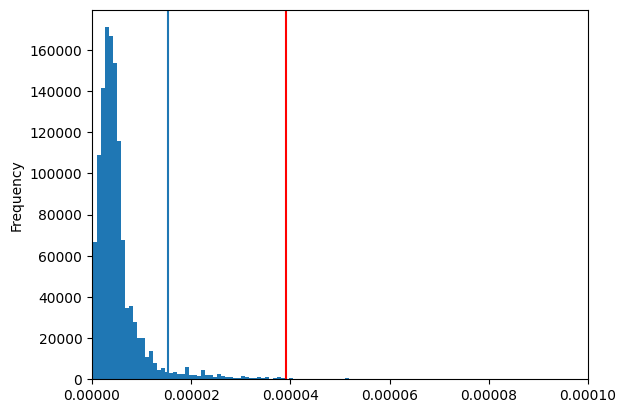

In [312]:
X = features.iloc[:,:-1]
y = features['labelnumber']

variancedistribution = X.var()

variancedistribution = pd.DataFrame(variancedistribution).reset_index()
variancedistribution.columns = ['token' , 'var']

q1 = variancedistribution['var'].quantile(.99)
q2 = variancedistribution['var'].quantile(0.95)

varplt = variancedistribution['var'].plot.hist(density = True, bins = 10000 , xlim = (0,.0001))
varplt.axvline(q1, color = 'r')
varplt.axvline(q2)

print(varplt)

only tokens withen the the threshold pracet will be filtered out.

In [313]:
threshold = str(q1)
threshold2 = str(q2)

varianceselected =  variancedistribution.query(threshold2 + ' <= var <= ' + threshold)
print(varianceselected)


                               token  var
15                      abandon deal 0.00
19                  abandoned dreams 0.00
20           abandoned dreams taking 0.00
67                 abdulelah al amri 0.00
68                abdulelah al malki 0.00
...                              ...  ...
161536  zielinski robert lewandowski 0.00
161602                zlotys billion 0.00
161624                zlotys million 0.00
161644                  zone central 0.00
161645            zone central banks 0.00

[6472 rows x 2 columns]


as random sample from the selected tokens is genrated to control the tokens number in case it is very high. this is to keep the algorithems fast.

In [268]:
grabsample = sample_without_replacement(len(varianceselected),5000 )
varianceselected = varianceselected.iloc[grabsample,:]
featureselected = features[varianceselected['token']]
featureselected

,losses netherlands,banks aim reducing,press cited,covid cases,robert lewandowski scored,final game argentina,moscow nov,cancelled afternoon time,russia cut,light current,...,kicking world cup,memphis depay,range partners,move forward,gave poland lead,unleashed wave missiles,mexico guillermo ochoa,przemyslaw frankowski karol,croatia group,due muscle
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
554,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
555,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
556,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [269]:
articlelabels = fulldata['labelnumber'].sort_values().unique()
articlelabels # categories of article labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [270]:
y = features.iloc[:,-1]

In [271]:


X_train, X_test, y_train, y_test = train_test_split(featureselected, y , test_size=0.4, random_state= 4545 )


In [314]:
def runtest(model):
    model.fit(X_train, y_train)
    modelpredictions = model.predict(X_test)
    try:
        modelpredictionsproba = model.predict_proba(X_test)
        tkc = top_k_accuracy_score(y_test, modelpredictionsproba, labels= articlelabels)
        ba = 'not applicable'
    except:
        tkc = 'not applicable'
    ba = balanced_accuracy_score(y_test, modelpredictions)
    report = classification_report(y_test, modelpredictions, zero_division= True, digits = 5)
    print(report)
    print('Top K accuracy score: ', tkc)
    return tkc



In [326]:
tree = ExtraTreeClassifier(min_samples_split= 22,
                            max_features=20,
                             random_state = 555)
runtest(tree)


              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000         1
           1    1.00000   0.00000   0.00000         2
           2    0.64000   0.36364   0.46377        44
           3    1.00000   0.00000   0.00000         1
           4    1.00000   0.00000   0.00000         2
           5    0.00000   0.00000   0.00000         1
           6    1.00000   0.50617   0.67213        81
           7    1.00000   0.00000   0.00000         4
           8    0.28571   0.11765   0.16667        17
           9    1.00000   0.00000   0.00000         3
          10    0.43243   0.94118   0.59259        68

    accuracy                        0.55357       224
   macro avg    0.75983   0.26624   0.26320       224
weighted avg    0.69831   0.55357   0.53115       224

Top K accuracy score:  0.7544642857142857


0.7544642857142857

In [329]:
bagging2 = BaggingClassifier(tree,
                            random_state= 555,
                            n_estimators= 150,
                            bootstrap= False) # limiting number of tokens
runtest(bagging2)

              precision    recall  f1-score   support

           0    1.00000   0.00000   0.00000         1
           1    1.00000   0.00000   0.00000         2
           2    0.84848   0.63636   0.72727        44
           3    0.00000   0.00000   0.00000         1
           4    1.00000   0.00000   0.00000         2
           5    1.00000   0.00000   0.00000         1
           6    0.97368   0.91358   0.94268        81
           7    1.00000   0.00000   0.00000         4
           8    1.00000   0.29412   0.45455        17
           9    1.00000   0.00000   0.00000         3
          10    0.61468   0.98529   0.75706        68

    accuracy                        0.77679       224
   macro avg    0.85790   0.25721   0.26196       224
weighted avg    0.83929   0.77679   0.74805       224

Top K accuracy score:  0.8571428571428571


0.8571428571428571

confusion matrix sugests supports hadling data balance.

In [330]:
print(confusion_matrix(y_true= y_test,y_pred= bagging2.predict(X_test),labels= articlelabels))
y_test.sort_values().value_counts()

[[ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  1  0  0  0 15]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 74  0  0  0  7]
 [ 0  0  1  0  0  0  0  0  0  0  3]
 [ 0  0  1  1  0  0  0  0  5  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  1  0  0  0 67]]


6     81
10    68
2     44
8     17
7      4
9      3
1      2
4      2
0      1
3      1
5      1
Name: labelnumber, dtype: int64

In [276]:
def plot_top_words(model, feature_names, n_top_words, title, r, c):
    fig, axes = plt.subplots(r, c, figsize=(40, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.9)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [277]:
df = pd.DataFrame(columns=['Ntopic','batch', 'Pr', 'coh'])

for i in np.arange(2,30,2):
    for j in np.arange(20,200,40):
        lda = LatentDirichletAllocation(n_components= i,
         batch_size= j,
         max_iter=30,
         random_state= 3434)
        lda.fit(featureselected)
        coh = metric_coherence_gensim(measure='u_mass', 
                        top_n=i, 
                        topic_word_distrib=lda.components_, 
                        dtm= np.matrix(featureselected),
                        vocab= featureselected.columns.values)
        df2 = pd.DataFrame({'Ntopic': i,
                            'batch': j,
                            'Pr': lda.perplexity(featureselected),
                            'coh': coh})
        df = pd.concat([df,df2], ignore_index= True)


In [278]:
df

,Ntopic,batch,Pr,coh
0,2,20,20894.36,-0.69
1,2,20,20894.36,-23.61
2,2,60,20894.36,-0.69
3,2,60,20894.36,-23.61
4,2,100,20894.36,-0.69
...,...,...,...,...
1045,28,180,2040975409.44,-0.48
1046,28,180,2040975409.44,-17.89
1047,28,180,2040975409.44,-15.06
1048,28,180,2040975409.44,-12.90


<AxesSubplot: title={'center': 'N topics VS Perplexity'}, xlabel='Ntopic', ylabel='Pr'>

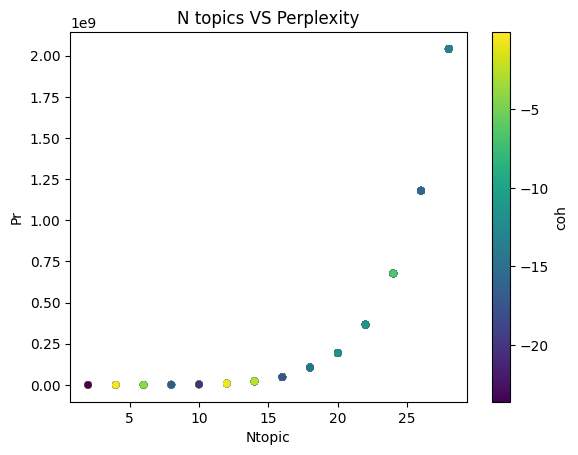

In [279]:
df.plot.scatter(x="Ntopic", y="Pr", title = 'N topics VS Perplexity', color = 'coh')


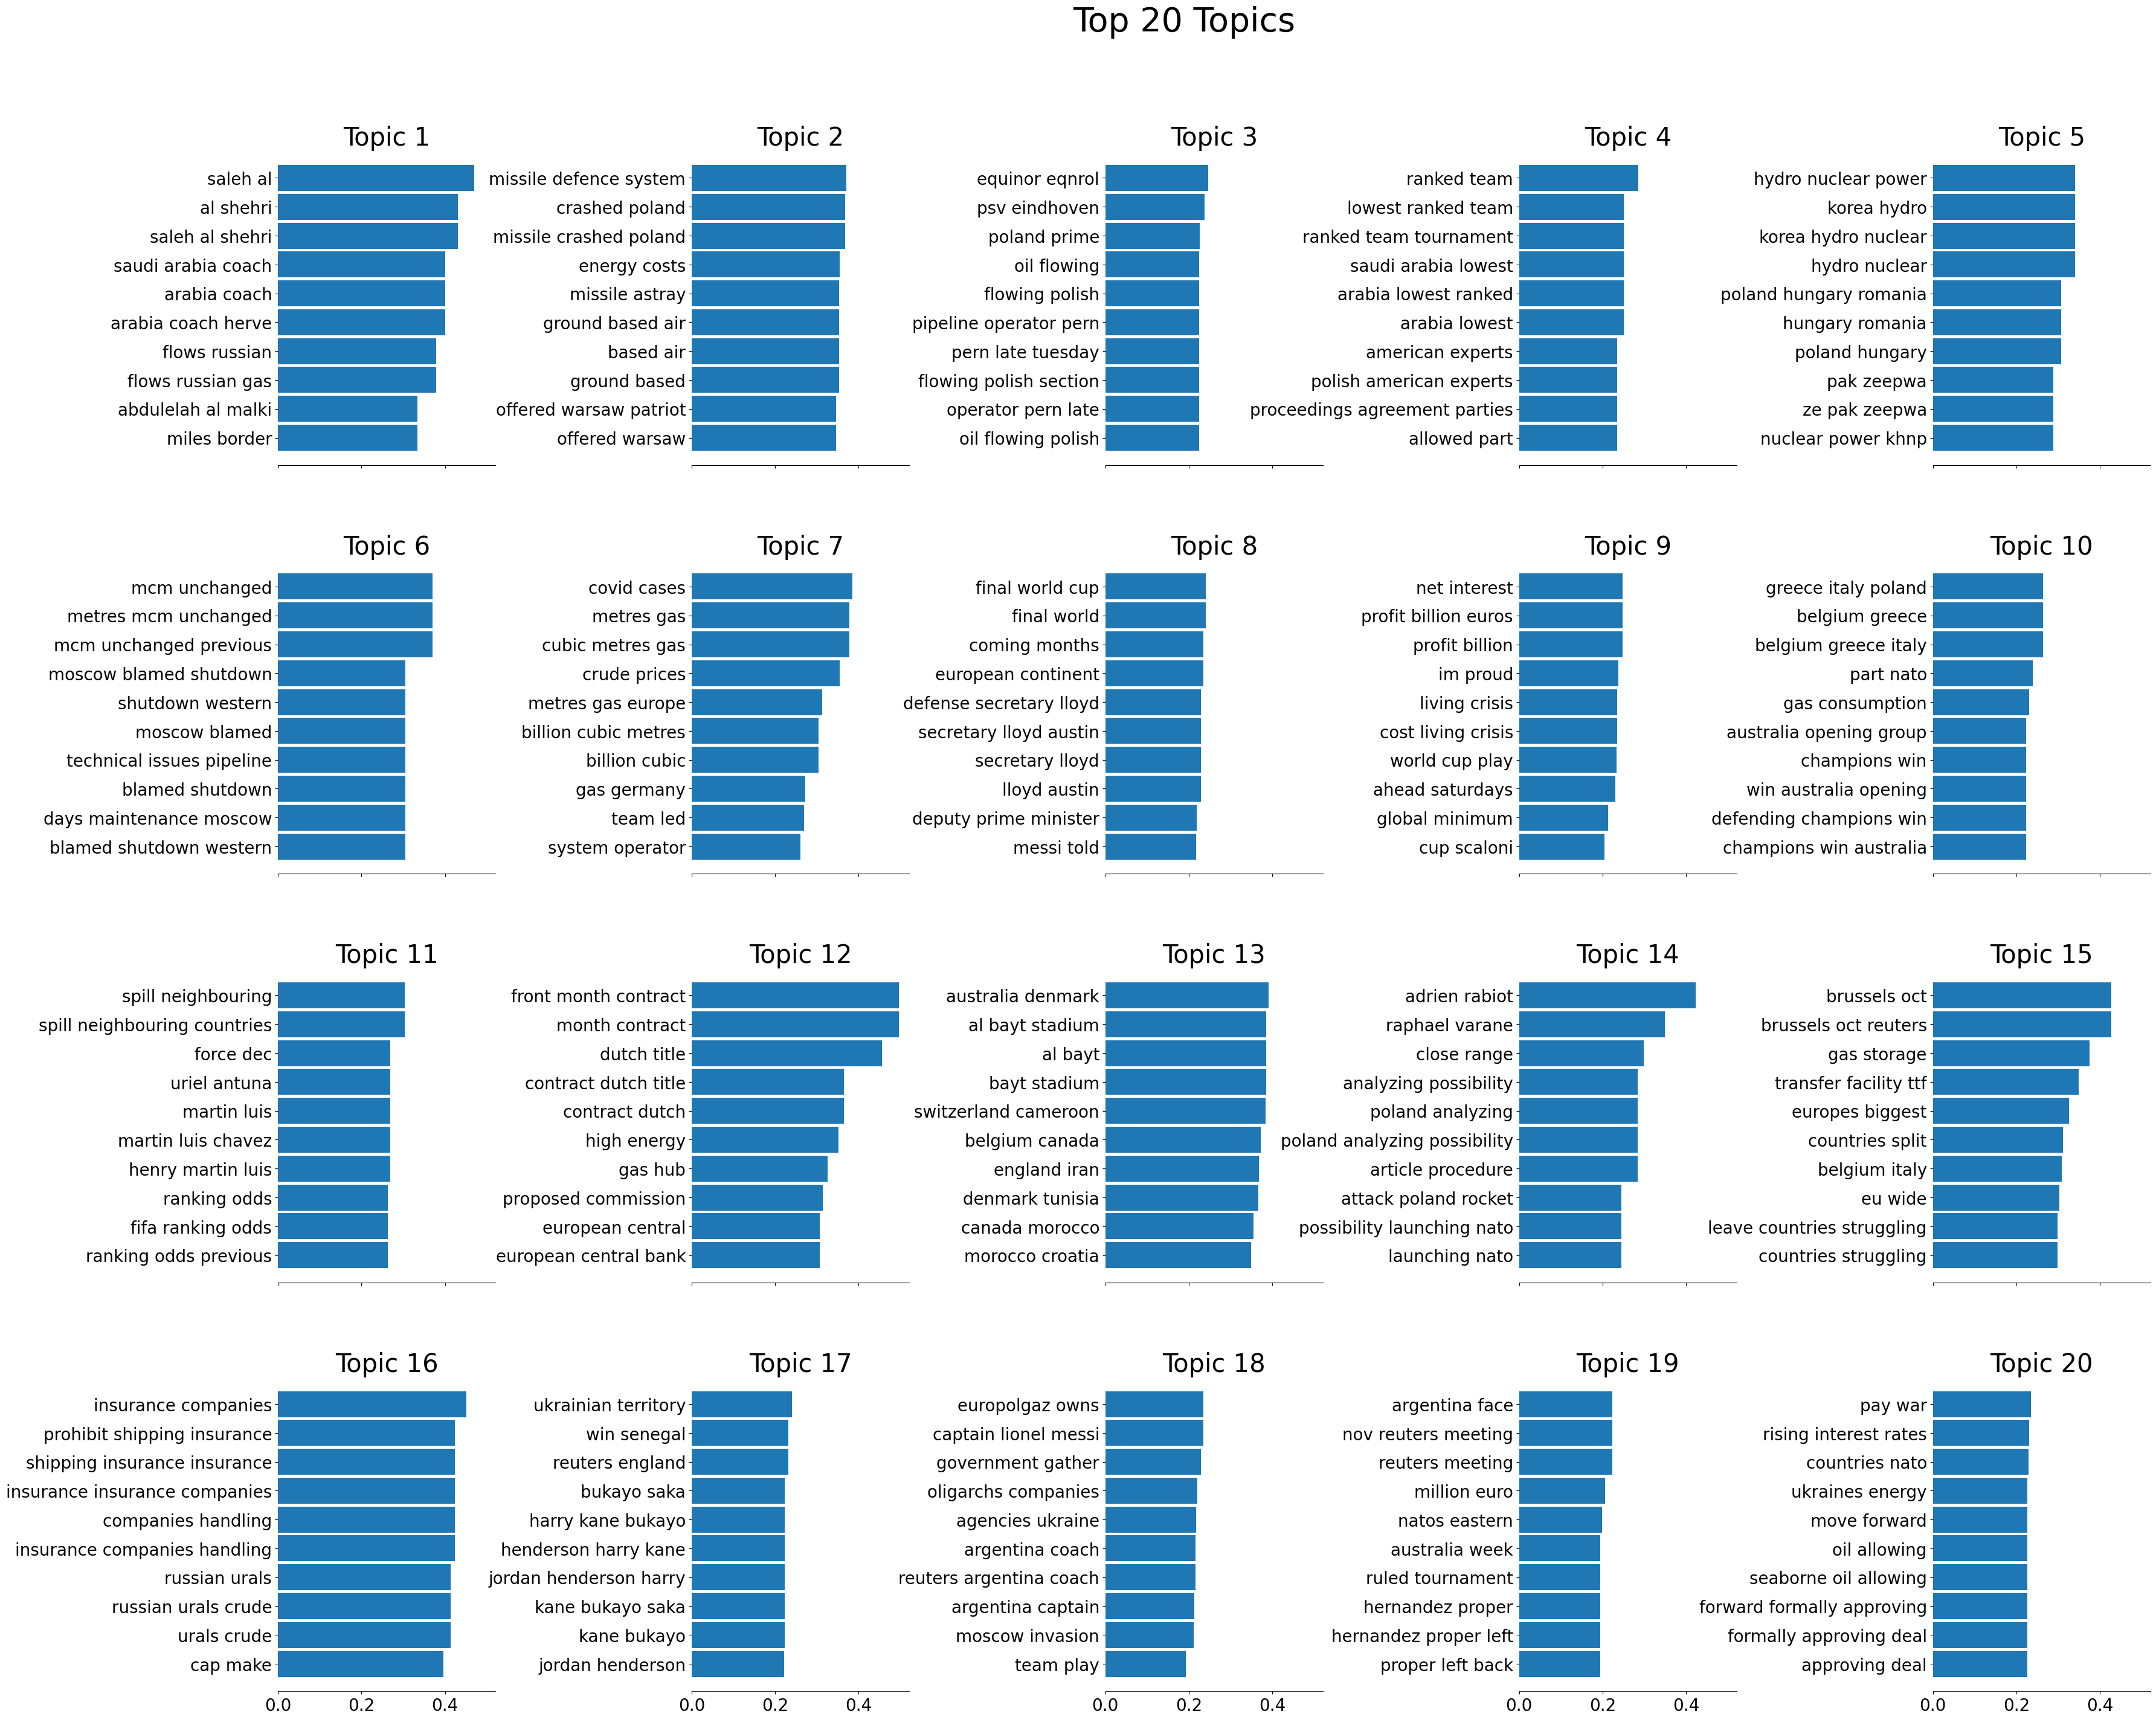

In [333]:
lda = LatentDirichletAllocation(n_components= 20, batch_size= 25, random_state= 3434 )
lda.fit(featureselected)
plot_top_words(lda, lda.feature_names_in_  , 10, 'Top 20 Topics', 4,5)

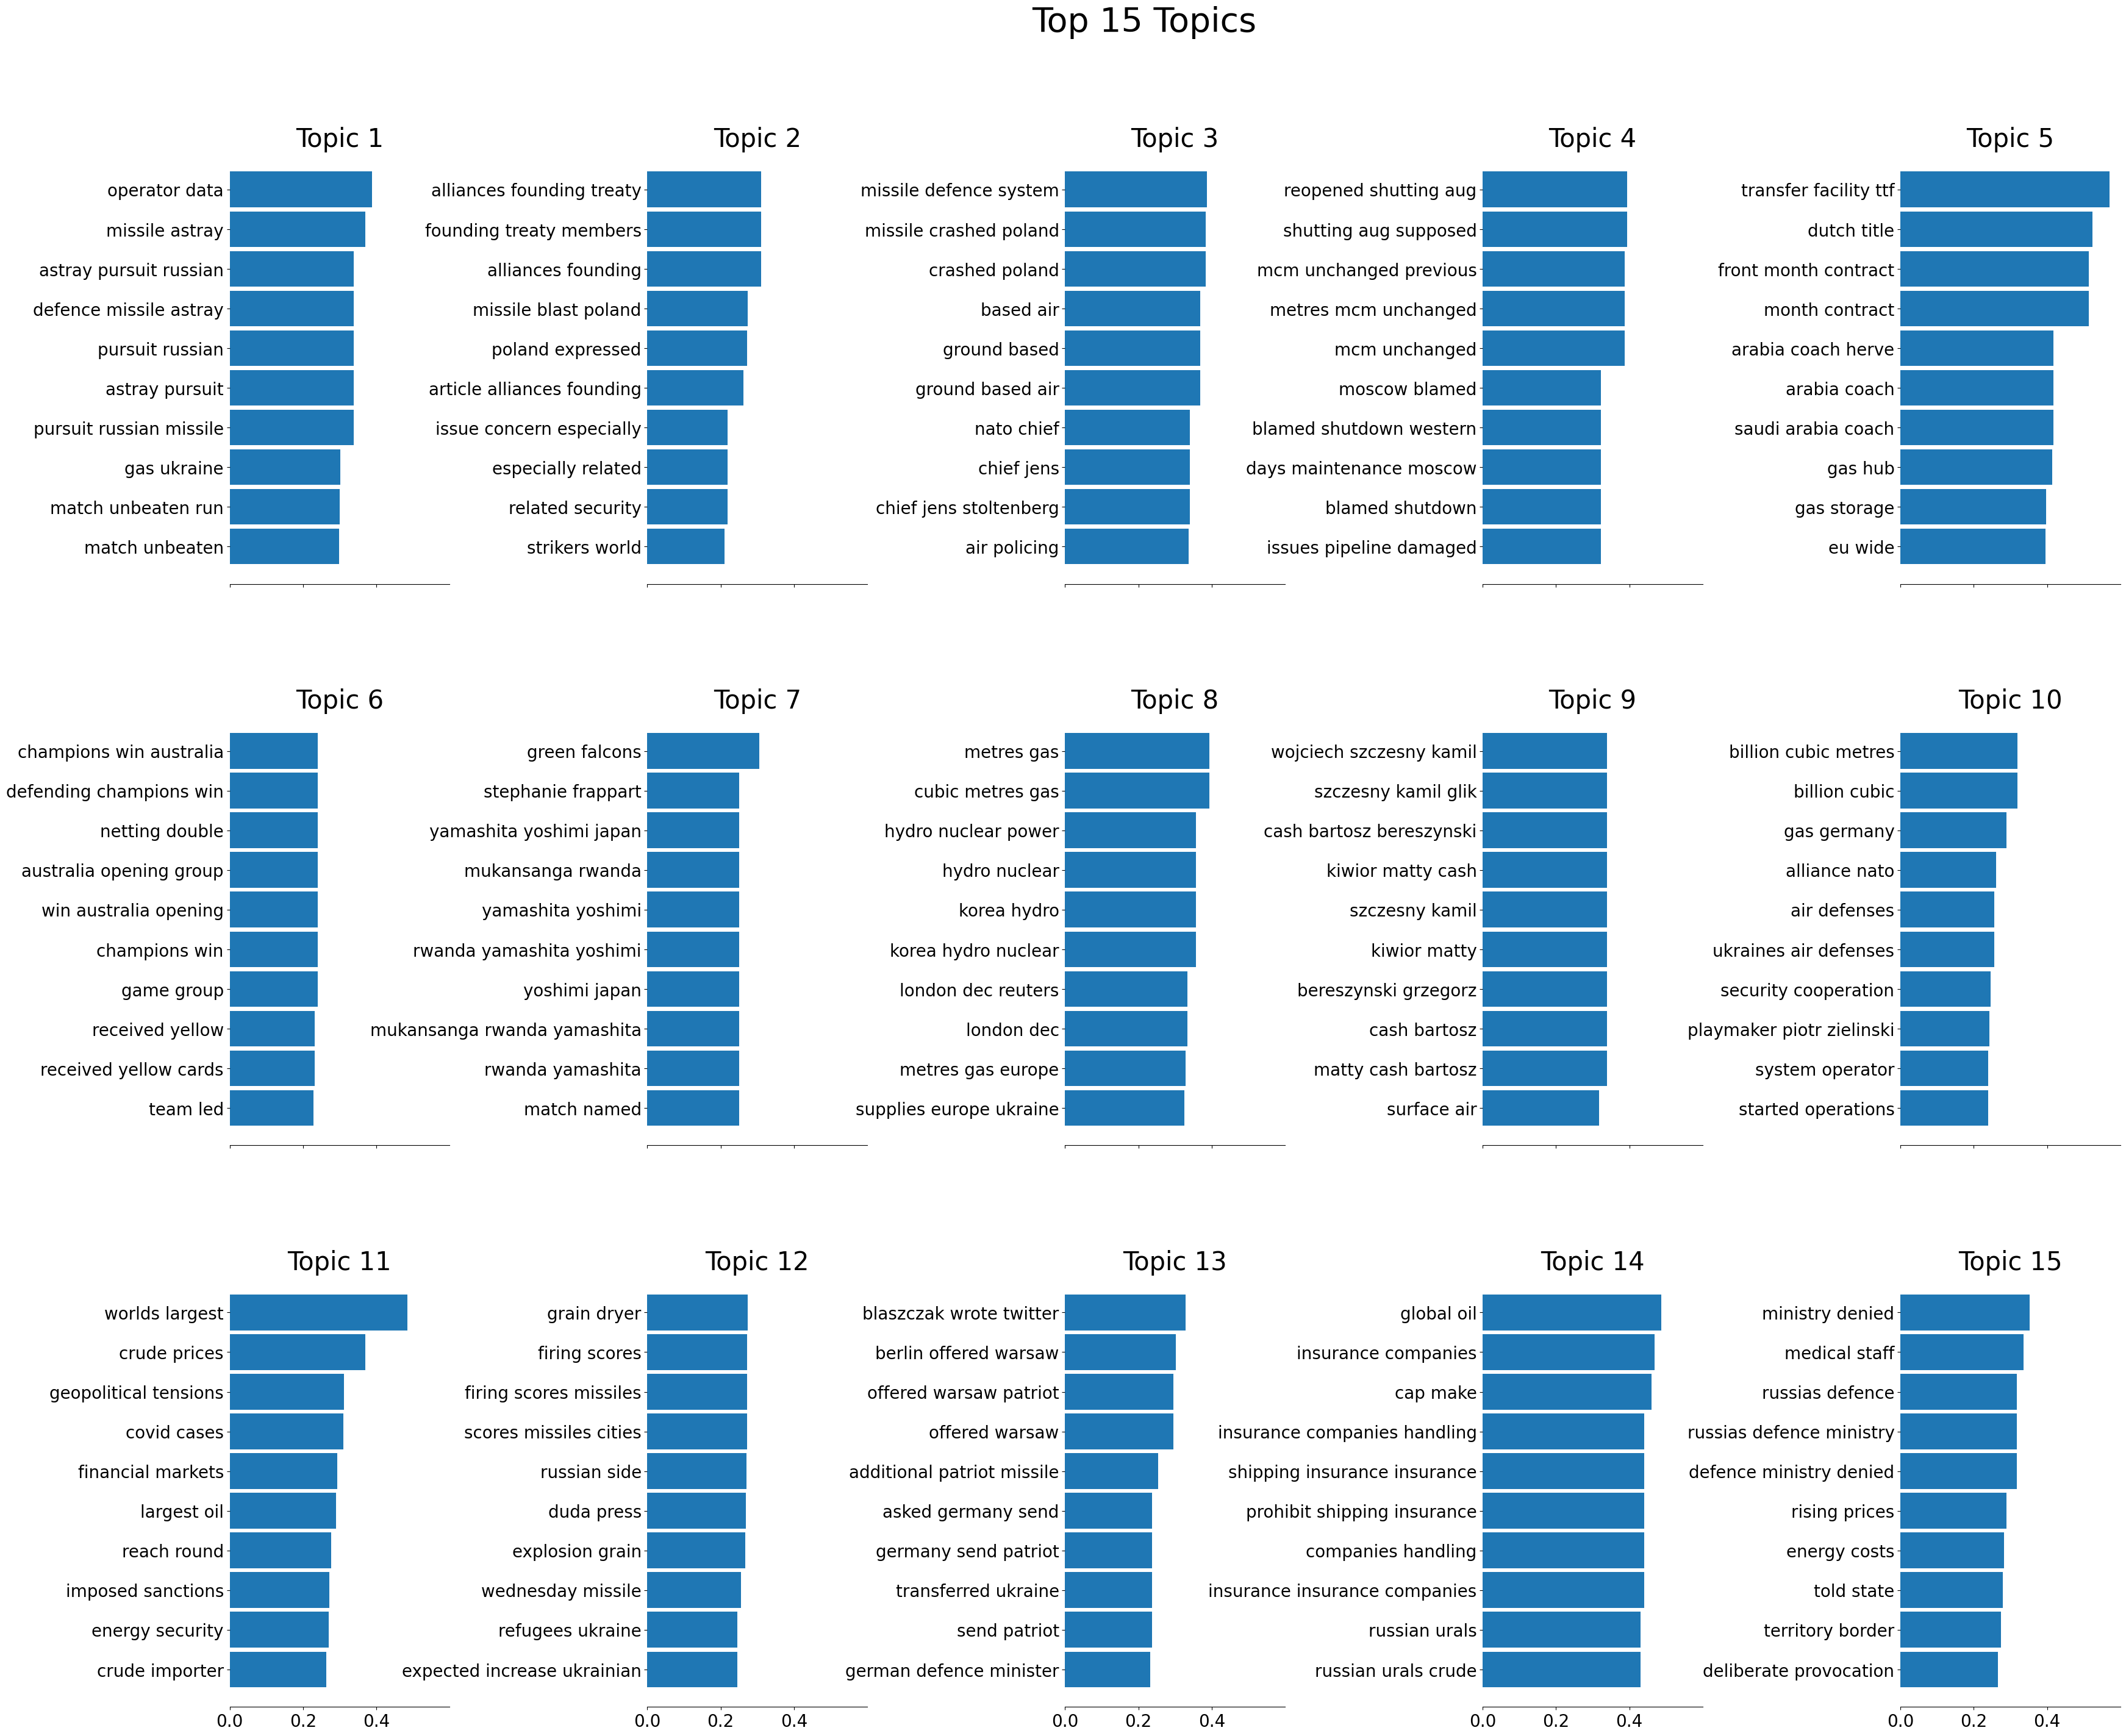

In [334]:
lda = LatentDirichletAllocation(n_components= 15, batch_size= 25, random_state= 3434 )
lda.fit(featureselected)
plot_top_words(lda, lda.feature_names_in_  , 10, 'Top 15 Topics', 3,5)

In [291]:

tokencreator = CountVectorizer(
    encoding = 'utf-8',
    strip_accents = 'ascii',
    stop_words = stopwordscustom.tolist(),
    ngram_range = (2,3),
    analyzer = 'word',
    vocabulary=featureselected.columns
   
)
dtm = tokencreator.fit_transform(articlesflat)

tfv = TfidfVectorizer(
    encoding = 'utf-8',
    strip_accents = 'ascii',
    stop_words = stopwordscustom.tolist(),
    ngram_range = (2,3),
    analyzer = 'word',
    vocabulary=featureselected.columns,
    use_idf= False
    
    
)
dtmtfv = tokencreator.fit_transform(articlesflat)

ldadtm = LatentDirichletAllocation(n_components= 25, batch_size= 25, random_state= 3434 )
ldadtm.fit(dtm)




c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


LatentDirichletAllocation(batch_size=25, n_components=25, random_state=3434)

In [292]:
import pyLDAvis.sklearn
vis = pyLDAvis.sklearn.prepare(ldadtm, dtm, tfv )
pyLDAvis.save_html(vis, 'lda.html')

c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Hasna\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
